In [1]:
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from skimage import io
from os.path import expanduser
from tqdm import tqdm
HOME = expanduser("~")
import os
import cv2 as cv
import math
import pandas as pd
#%matplotlib inline

In [2]:
#DIR = os.path.join(HOME, 'programming', 'dk39')
DIR = '/net/birdstore/Active_Atlas_Data/data_root/pipeline_data/DK39'
ORIENTED = os.path.join(DIR, 'preps', 'oriented')
RESIZED = os.path.join(DIR, 'preps', 'resized')
THUMBNAIL = os.path.join(DIR, 'preps', 'thumbnail')
MASKED = os.path.join(DIR, 'preps', 'masked')
DIM = os.path.join(DIR, 'preps', 'dim')
CH1 = os.path.join(DIR, 'CH1')
INPUT = os.path.join(DIR, 'preps', 'oriented')
OUTPUT = MASKED
files = sorted(os.listdir(INPUT))

In [ ]:
badi = [31,34, 36, 56,72, 73, 83, 110, 111, 113, 116, 147, 176, 252, 263, 270, 271, 296, 297, 300, 301, 317, 318,
       324, 327, 336, 358, 380,382, 434,435, 438, 452, 466]
bads = [files[b] for b in badi]

In [3]:
def everything(img, rotation):
    img = get_last_2d(img)
    img = np.rot90(img, rotation)
    img = crop_rows(img, 50)
    return img.astype('uint16')

def get_last_2d(data):
    if data.ndim <= 2:
        return data    
    m,n = data.shape[-2:]
    return data.flat[:m*n].reshape(m,n)

def crop_rows(img,cropy):
    y,x = img.shape
    starty = y + cropy
    return img[0:starty,:]

def lognorm(img, limit):
    lxf = np.log(img + 0.005)
    lxf = np.where(lxf < 0, 0, lxf)
    xmin = min(lxf.flatten())
    xmax = max(lxf.flatten())
    return lxf * limit / (xmax - xmin) + xmax * limit / (xmax - xmin)  # log of data and stretch 0 to 255


def linnorm(img, limit):
    flat = img.flatten()
    hist, bins = np.histogram(flat, limit + 1)
    cdf = hist.cumsum()  # cumulative distribution function
    cdf = limit * cdf / cdf[-1]  # normalize
    # use linear interpolation of cdf to find new pixel values
    img_norm = np.interp(flat, bins[:-1], cdf)
    img_norm = np.reshape(img_norm, img.shape)
    #img_norm = limit - img_norm
    return img_norm.astype('uint16')

def get_max_size(INPUT):
    widths = []
    heights = []
    files = os.listdir(INPUT)
    midpoint = len(files)
    files = files[midpoint-5:midpoint+5]
    files = files[-5:-1]
    for file in files:
        img = io.imread(os.path.join(INPUT, file))
        heights.append(img.shape[0])
        widths.append(img.shape[1])
        img = None

    max_width = max(widths)
    max_height = max(heights)

    return max_width, max_height

def is_barcode(rect, min_width, min_height):
    x,y,w,h = rect
    area = w * h
    result = ( (x + y > 0) and w > min_width and h > min_height and area > 1000)
    
    if result and False:
        print ('SN=%s rectangle size: x=%s y=%s w=%s h=%s area=%s' 
               %(section_number,x,y,w,h,area))
    
    return result


def all_rects(input, min_width, min_height):
    copied = np.copy(input)
    lowVal = 12
    highVal = 10000
    img_mask = cv.inRange(input, lowVal, highVal)
    contours, hierarchy = cv.findContours(img_mask, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
    contour_sizes = [(cv.contourArea(contour), contour) for contour in contours]
    contours_poly = [None]*len(contours)
    boundRect = [None]*len(contours)
    color = (60000,60000,60000)
    for i, c in enumerate(contours):
        contours_poly[i] = cv.approxPolyDP(c, 3, True)
        boundRect[i] = cv.boundingRect(contours_poly[i])
        if is_barcode(boundRect[i],  min_width, min_height):
            #cv.rectangle(copied, (int(boundRect[i][0]), int(boundRect[i][1])), \
            #  (int(boundRect[i][0]+boundRect[i][2]), int(boundRect[i][1]+boundRect[i][3])), color, 2)    
            cv.rectangle(copied, boundRect[i], color, 2)    
    return copied

def create_rect(input, min_width, min_height):
    copied = np.copy(input)
    lowStart = 12
    highStart = 23000
    v = np.median(img)
    sigma = 0.33
    lowVal = int(max(lowStart, (1.0 - sigma) * v))
    
    hist = np.histogram(input.flatten(), bins=10)
    highVal = int(hist[1][5])
    #highVal = 19660
    img_mask = cv.inRange(input, lowVal, highVal)
    contours, hierarchy = cv.findContours(img_mask, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
    contour_sizes = [(cv.contourArea(contour), contour) for contour in contours]
    contours_poly = [None]*len(contours)
    boundRect = [None]*len(contours)
    centers = [None]*len(contours)
    color = (60000,60000,60000)
    areas = []
    rects = []
    for i, c in enumerate(contours):
        contours_poly[i] = cv.approxPolyDP(c, 3, True)
        boundRect[i] = cv.boundingRect(contours_poly[i])        
        if is_barcode(boundRect[i],  min_width, min_height):
            rect = boundRect[i]
            x,y,w,h = rect
            areas.append(w*h)
            rects.append(rect)
            
    if len(rects) > 0:
        big_rect = rects[areas.index(max(areas))]
        cv.rectangle(copied, big_rect, color, 2)
    
    return copied, lowVal, highVal


def crop_brain(input, min_width, min_height):
    #new_img = np.zeros([max_height, max_width])
    copied = np.copy(input)
    lowStart = 12
    highStart = 23000
    v = np.median(img)
    sigma = 0.33
    lowVal = int(max(lowStart, (1.0 - sigma) * v))
    hist = np.histogram(input.flatten(), bins=10)
    #highVal = 19660
    highVal = int(hist[1][5])
    # creation of mask
    img_mask = cv.inRange(input, lowVal, highVal)
    contours, hierarchy = cv.findContours(img_mask, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
    contour_sizes = [(cv.contourArea(contour), contour) for contour in contours]
    contours_poly = [None]*len(contours)
    boundRect = [None]*len(contours)
    #centers = [None]*len(contours)
    areas = []
    rects = []
    for i, c in enumerate(contours):
        contours_poly[i] = cv.approxPolyDP(c, 3, True)
        boundRect[i] = cv.boundingRect(contours_poly[i])        
        if is_barcode(boundRect[i], min_width, min_height):
            rect = boundRect[i]
            x,y,w,h = rect
            areas.append(w*h)
            rects.append(rect)
    if len(rects) > 0:
        big_rect = rects[areas.index(max(areas))]
        x,y,w,h = big_rect
        copied = copied[y:y+h,x:x+w]
    return copied, lowVal, highVal

def simple_resample(fixed_image, moving_image):
    return  sitk.Elastix(fixed_image, moving_image)

def get_mins(shape, section_number):
    min_size = 50
    rows = shape[0]
    cols = shape[1]
    min_width = (cols // 8) + section_number + min_size
    min_height = (rows // 12) + section_number + min_size
    return min_width, min_height

def place_image(img, max_width, max_height):
    zmidr = max_height // 2
    zmidc = max_width // 2
    startr = zmidr - (img.shape[0] // 2)
    endr = startr + img.shape[0]
    startc = zmidc - (img.shape[1] // 2)
    endc = startc + img.shape[1]
    new_img = np.zeros([max_height, max_width])
    try:
        new_img[startr:endr,startc:endc] = img
    except:
        print('could not create new img', file)
        
    return new_img.astype('uint16')


def find_main_blob(stats,image):
    height,width=image.shape
    df=pd.DataFrame(stats)
    df.columns=['Left','Top','Width','Height','Area']
    df['blob_label']=df.index
    df=df.sort_values(by='Area',ascending=False)

    for row in df.iterrows():
        Left=row[1]['Left']
        Top=row[1]['Top']
        Width=row[1]['Width']
        Height=row[1]['Height']
        corners= int(Left==0)+int(Top==0)+int(Width==width)+int(Height==height)
        if corners<=2:
            return row


def scale_and_mask(src,mask,epsilon=0.01):
    vals=np.array(sorted(src[mask>10]))
    ind=int(len(vals)*(1-epsilon))
    _max=vals[ind]
    # print('thr=%d, index=%d'%(vals[ind],index))
    _range=2**16-1
    scaled=src*(45000./_max)
    scaled[scaled>_range]=_range
    scaled=scaled*(mask>10)
    return scaled,_max

def find_threshold(src):
    fig = matplotlib.figure.Figure()
    ax = matplotlib.axes.Axes(fig, (0,0,0,0))
    n,bins,patches=ax.hist(src.flatten(),160);
    del ax, fig
    min_point=np.argmin(n[:5])
    thresh = (min_point*64000/180+400)
    #v = np.median(src)
    #thresh = int(max(min_point, (1.0 - sigma) * v))
    #thresh = min_point * 136 + 100
    #thresh = int(max(min_point, (1.0 - sigma) * v))
    thresh1 = int(min(1200, thresh))
    return min_point, thresh1

In [4]:
def roundup(x):
    return int(math.ceil(x / 10.0)) * 10

#max_width, max_height = get_max_size(INPUT)
#1738x1048
#50086x27949
max_width = 1740
max_height = 1050
#max_width = 50100
#max_height = 34000

In [5]:
print(max_width, max_height, len(files))

1740 1050 19


In [8]:
# get oriented for comparison
img_inputs = []
img_outputs = []
file_inputs = []
titles = []
section_number = 0
midpoint = len(files) // 2
#tmp_img = files[67]
#tfiles = [tmp_img]
dels = os.listdir(OUTPUT)
for d in dels:
    os.unlink(os.path.join(OUTPUT, d))

for i, file in enumerate(tqdm(files)):
    infile = os.path.join(INPUT, file)
    img = io.imread(infile)
    #img = cv.imread(infile, -1)
    img_inputs.append(img)
    file_inputs.append(file)
    #img = crop_rows(img, 30)
    #min_width, min_height = get_mins(img.shape, section_number)
    #img = linnorm(img, 2**15)
    #img, low, high = create_rect(img, min_width, min_height) 
    #img, low, high = crop_brain(img, min_width, min_height)
    min_value, threshold = find_threshold(img)

    titles.append((min_value,threshold))

    ###### Threshold it so it becomes binary
    #threshold = 272
    ret, threshed = cv.threshold(img,threshold,255,cv.THRESH_BINARY)
    threshed=np.uint8(threshed)

    ###### Find connected elements
    # You need to choose 4 or 8 for connectivity type
    connectivity = 4  
    output = cv.connectedComponentsWithStats(threshed, connectivity, cv.CV_32S)

    # Get the results
    # The first cell is the number of labels
    num_labels = output[0]
    # The second cell is the label matrix
    labels = output[1]
    # The third cell is the stat matrix
    stats = output[2]
    # The fourth cell is the centroid matrix
    centroids = output[3]
    
    # Find the blob that corresponds to the section.
    row=find_main_blob(stats,img)
    blob_label=row[1]['blob_label']
    
    #extract the blob
    blob=np.uint8(labels==blob_label)*255
    
    #Perform morphological closing
    kernel10 = np.ones((10,10),np.uint8)
    closing = cv.morphologyEx(blob, cv.MORPH_CLOSE, kernel10, iterations=5)
    del blob
    # scale and mask
    scaled,_max=scale_and_mask(img,closing)
    del closing    
    img = place_image(scaled, max_width, max_height)
    del scaled
    img_outputs.append(img)
    outpath = os.path.join(OUTPUT, file)    
    cv.imwrite(outpath, img.astype('uint16'))
    if i <= midpoint:
        section_number += 2
    else:
        section_number -= 2
    del img


100%|██████████| 19/19 [00:03<00:00,  5.57it/s]


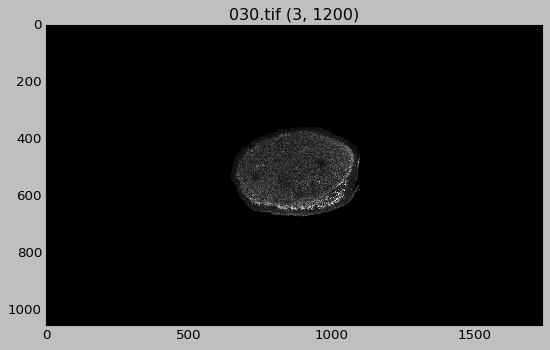

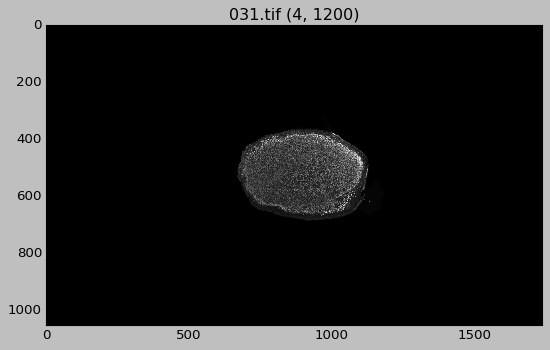

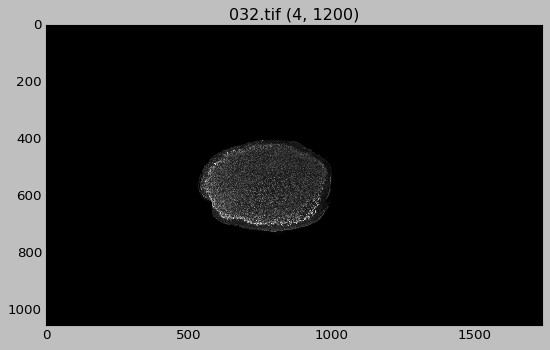

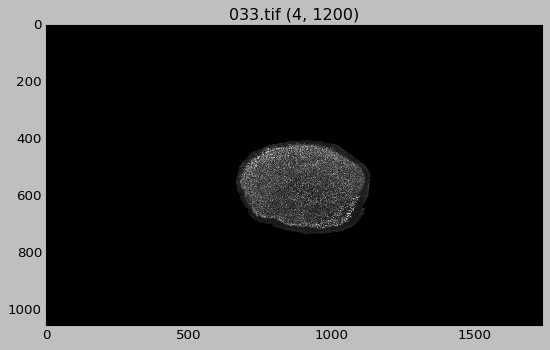

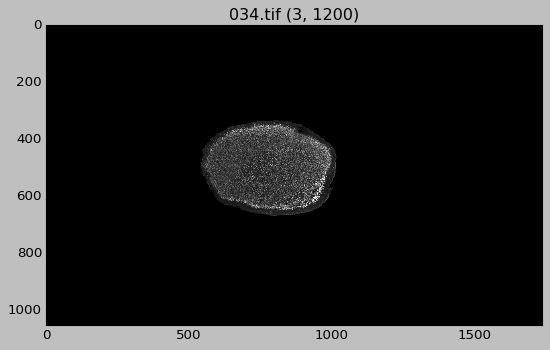

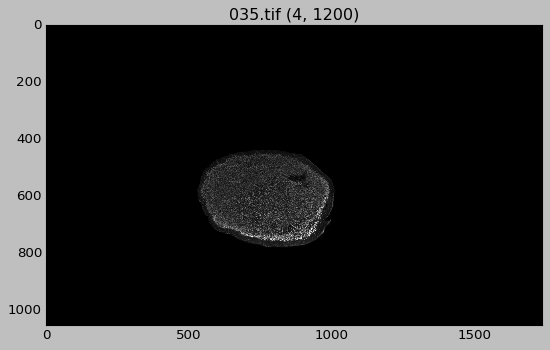

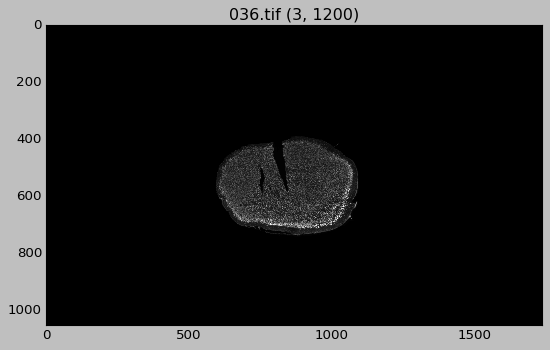

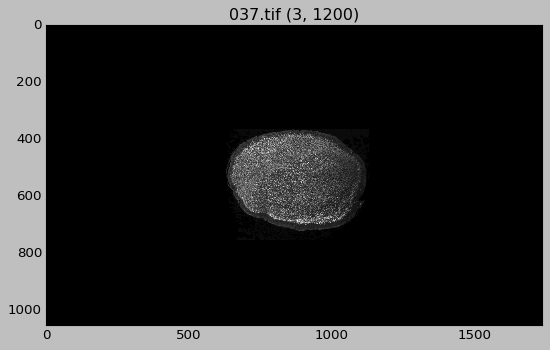

In [7]:
# display images
# check alignment
start, finish = (10,-1)
displays = img_outputs[start:finish]
tdisplays = titles[start:finish]
names = file_inputs[start:finish]
plt.style.use('classic')
for name,img,title in zip(names,displays, tdisplays):    
    plt.figure()
    plt.title('{} {}'.format(name, str(title)))
    #plt.title('{}'.format(name))
    plt.imshow(img, cmap='gray')
    plt.show()

In [ ]:
len(bads)

In [ ]:
i = 14
test_img = img_inputs[i]
print(test_img.shape)
test_img = crop_rows(test_img, 30)
plt.figure()
plt.rcParams.update({'figure.figsize': [8, 6]})
plt.title('min width, min height: {} L,H {}'.format(titles[i], values[i]))
plt.imshow(test_img, cmap='gray')
plt.show()


In [ ]:
flat = test_img.flatten()
fmax = int(flat.max())
fmin = int(flat.min())
hist = np.histogram(flat)
print(fmin, fmax, test_img.dtype, test_img.shape, np.median(test_img))

In [ ]:
hist[1]

In [ ]:
hist = np.histogram(flat, bins=50)
hist[1][2]

In [ ]:
hist[1][3]